### 목적
- 해당 노트북의 목적은 EDA(Exploratory Data Analysis)를 통한 실험 아이디어 도출에 있습니다.  
- 여러 데이터 전처리 방법과 아이디어를 소개하고, 이를 시각화를 통해 보여줍니다.   
- 빈약한 부분이나 오류가 있을 수 있습니다. 관련하여 댓글로 알려주시거나 질문해주시면 감사하겠습니다.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 모든 경고 메시지 무시
warnings.filterwarnings("ignore")

### 데이터 불러오기

In [2]:
train = pd.read_csv("../data/raw/train.csv", encoding="UTF-8")
dev = pd.read_csv("../data/raw/dev.csv", encoding="UTF-8")
test = pd.read_csv("../data/raw/test.csv", encoding="UTF-8")
print("train dataset count:", len(train))
print("dev dataset count:", len(dev))
print("test dataset count:", len(test))

train dataset count: 9324
dev dataset count: 550
test dataset count: 1100


In [3]:
train.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


## Label 분포
- Label 값의 분포를 통해 데이터가 불균형한지, 숨겨진 특징은 없는지 확인할 수 있습니다.  
- 다양한 데이터 증강 기법이나 샘플링 기법 등을 적용할 아이디어를 얻을 수 있습니다.  

### Label 별 데이터셋 특징
아래 표는 작년 AI Tech 6기 4조에서 분석했던 내용을 가져왔습니다.

<div align='center'>

| Label 구간 | sentence_1 | sentence_2 | 특징 |
|:---:|:---|:---|:---|
| 5.0 | 검정고시가 페지되어야 한다고 봅니다 | 검정고시 페지해야 한다고 봅니다 | 문장부호의 개수 및 띄어쓰기, 조사가 생략되거나 하는 다소의 차이가 존재하나, 문장이 거의 일치합니다. |
| 4.0 ~ 4.9 | 나는 이걸 왜 보았을까?? | 이거 내가 왜 봤지? | 문장의 의미가 거의 일치하나, 단어의 어순이 다르거나 일부 단어가 유의어로 교체되었습니다. |
| 3.0 ~ 3.9 | 히딩크감독을 다시 대한민국 축구 감독으로 | 히딩크감독님을 모셔와야합니다 | 문장의 맥락이 거의 일치하나, 주요한 보어 혹은 목적어가 누락되거나 유의어 대체 등에서 뚜렷한 차이를 보입니다. |
| 2.0 ~ 2.9 | 대회 때문에 정신 없어서 오늘 올립니다. | 오늘은 대회로 바쁘지 않아서 올립니다. | 문장에서 다루는 주제와 상황은 유사하지만, 읽는 사람에 따라 다르게 해석될 여지가 있습니다. |
| 1.0 ~ 1.9 | 다크나이트와 함께 최고의 히어로물 | 히트했던 드라마인 각시탈 또한 제대로된 히어로물입니다; | 일부 단어가 일치하거나 주제는 유사하지만, 서로 다른 의미를 가지는 문장입니다. |
| 0.1 ~ 0.9 | 공짜로 주어지는 것은 아무 것도 없다. | 아무 것도 남는게 없다.. | 일부 단어는 일치하나, 맥락과 의미가 전혀 다릅니다. |
| 0.0 | 부모님 댁으로 받았는데 너무 맛있다고 하셔요!! ㅎㅎㅎ | 타고 싶은데 넘 비싸요 ㅎㅎ | 공통점이 없는 전혀 다른 문장입니다. |

</div>

In [17]:
def plot_label_count(df, df_name):
    grouped_data = df.groupby("label")["id"].count()
    grouped_data.plot(kind="bar", color="skyblue")
    plt.title(f"{df_name} label Count")
    plt.xlabel("label")
    plt.ylabel("Count")
    plt.show()


def plot_multiple_label_counts(dfs, df_names):
    num_experiments = len(df_names)
    num_cols = 2  # 한 줄에 두 개씩 배치
    num_rows = (num_experiments + 1) // num_cols  # 행의 수 계산

    # 전체 subplot 크기 설정
    fig, axes = plt.subplots(
        num_rows, num_cols, figsize=(18, 6 * num_rows)
    )  # subplot의 크기 설정

    for idx, df in enumerate(dfs):
        row = idx // num_cols
        col = idx % num_cols

        grouped_data = df.groupby("label")["id"].count()
        # subplot에 각각의 그래프 그리기
        if num_rows > 1:
            ax = axes[row, col]  # 2차원 배열에서 해당 위치의 subplot 지정
        else:
            ax = axes[col]  # 1차원 배열일 경우

        grouped_data.plot(kind="bar", color="skyblue", ax=ax)

        # subplot의 제목 및 축 설정
        ax.set_title(f"Label Count ({df_names[idx]})")
        ax.set_xlabel("label")
        ax.set_ylabel("Count")

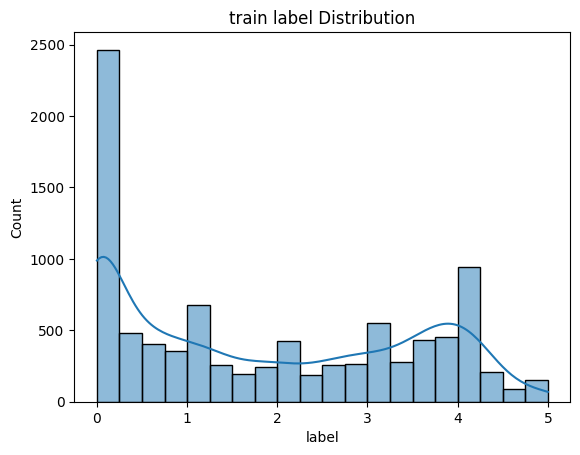

In [18]:
sns.histplot(train["label"], kde=True, bins=20)
plt.title("train label Distribution")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

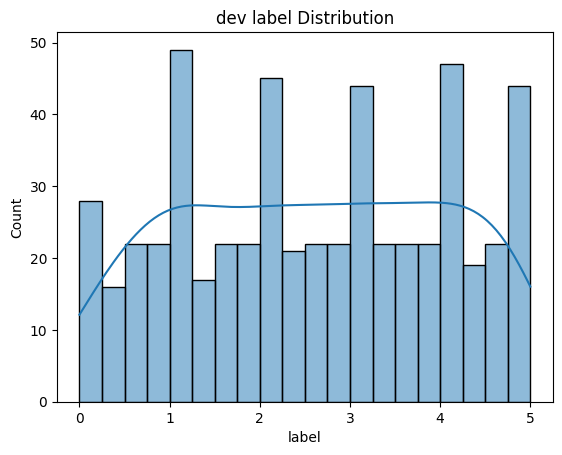

In [19]:
sns.histplot(dev["label"], kde=True, bins=20)
plt.title("dev label Distribution")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

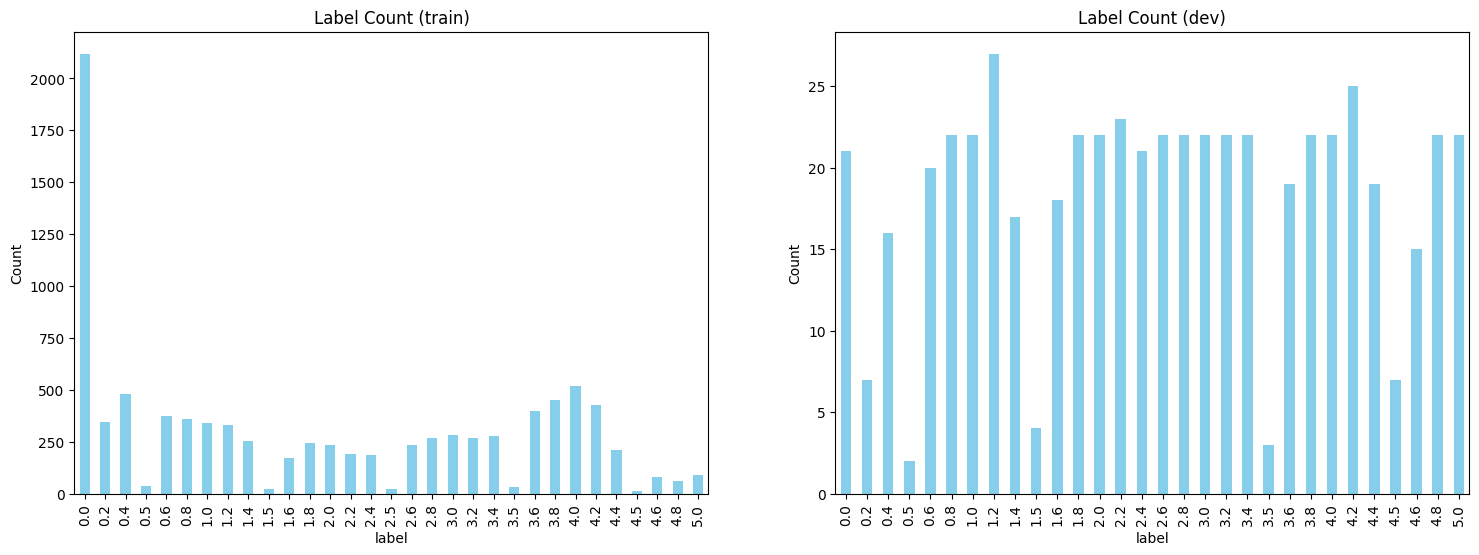

In [20]:
plot_multiple_label_counts([train,dev],["train","dev"])

In [6]:
# 정수 구간에 따라 분류
# df["label"].map(int) 사용 시 5점이 따로 분류된다.
train["label_int"] = pd.cut(
    train["label"],
    bins=[x for x in range(6)],
    labels=[x for x in range(5)],
    right=False,
)

dev["label_int"] = pd.cut(
    dev["label"],
    bins=[x for x in range(6)],
    labels=[x for x in range(5)],
    right=False,
)

In [7]:
# 0점대(0~0.99)가 나머지 점수대에 비해 3배 가까이 많다.
train.groupby("label_int")["id"].count()

label_int
0    3711
1    1368
2    1137
3    1715
4    1302
Name: id, dtype: int64

In [8]:
# 0점대(0~0.99)가 다소 적으나 나머지는 동일한 갯수로 고루 분포하는 것을 알 수 있다.
dev.groupby("label_int")["id"].count()

label_int
0     88
1    110
2    110
3    110
4    110
Name: id, dtype: int64

## 데이터 source
### source
데이터셋의 출처는 총 3가지 source로 구성되어 있습니다.  
- petition 데이터셋은 국민청원 게시판 제목 데이터로, 대체로 오탈자가 적은 격식체의 문장들로 구성되어 있습니다.  
- NSMC(Naver Sentiment Movie Corpus) 데이터셋은 네이버 영화 감성 분석 코퍼스로, 문어체와 구어체가 섞여 있었고, 일부 문장에서 특수문자가 발견되었습니다.  
- Slack 데이터셋은 Upstage에서 제공한 slack 데이터셋으로, 전반적으로 구어체의 문장으로 구성되어 있었으며, 오탈자와 함께 문장 부호, 특수문자(이모티콘, 이모지 등)가 발견되었습니다.  
### RTT
- RTT(round-trip translation)란 한국어 문장을 영어로 번역했다가 다시 한국어로 번역하여 유사한 문장 쌍을 생성하는 기법입니다.  
- 동일한 source에서 가져온 데이터셋에서도 RTT로 생성한 데이터와 아닌 데이터의 분포에는 차이를 보입니다.  
- RTT로 생성한 데이터셋은 비교적 높은 유사도가 큰 비중을 차지하는 모습을 보입니다. 이는 RRT 기법을 생각해볼 때 어쩌면 자연스러운 결과입니다.  

### Source 별 데이터셋 특징
아래 표는 작년 AI Tech 6기 4조에서 분석했던 내용을 가져왔습니다.  
<div align='center'>

| channel | sentence_1 | sentence_2 |
|:---:|:---|:---|
| **nsmc** | 혹평하신분들은 로맨틱코메디를 얼마나 심오하게 보시는분들인지는 모르겠지만 개인적으로는 가볍게 기분좋게 보기 좋은 영화라고 생각합니다.. | 로맨틱코미디를 비판하는 사람들이 얼마나 심한지는 모르겠지만 개인적으로는 가볍게 보기 좋은 영화라고 생각한다. |
|  | 울면서 본 영화다. | 울컥 하면서 보는 드라마입니다. |
|  | 킹콩이면 도대체 콩진호가 얼마나 큰 건가요? | . 콩진호가 나가신다! |
| **petition** | 심평원, 한전 회식카드지출비 해외출장비 지원자금 조사의뢰 건 | 공동주택 일자리안정자금에 대한 문제점(미화원, 경비원 2019년 임금 동결건) |
|  | 고등학생도 휴업 해주세요. | 근로자의 휴식권을 찾아주세요.. |
|  | 청소년법 폐지 간곡히 요청합니다 | 청소년보호법 폐지 간곡히 부탁드립니다. |
| **slack** | 제가 모르는 종목도 많이 알고 계셨습니다. | 제가 있던 테이블에서도 너무나 가슴 뛰는 아이디어도 많이 나누었습니다. |
|  | 두 분 어디 도장깨기 하러 가시는가요… ㅋㅋㅋ | 둘이 봉인을 어디서 뜯으려나... 하하하 |
|  | 너무 감사드립니다 ㅠㅠ | 너무 부럽습니다 ㅠㅠ |

</div>

In [9]:
train.groupby("source")["id"].count()

source
nsmc-rtt             788
nsmc-sampled        2296
petition-rtt         817
petition-sampled    2352
slack-rtt           1047
slack-sampled       2024
Name: id, dtype: int64

In [33]:
dev.groupby("source")["id"].count()

source
nsmc-rtt             48
nsmc-sampled        127
petition-rtt         65
petition-sampled    127
slack-rtt            84
slack-sampled        99
Name: id, dtype: int64

In [10]:
test.groupby("source")["id"].count()

source
nsmc-rtt            107
nsmc-sampled        261
petition-rtt        137
petition-sampled    256
slack-rtt           158
slack-sampled       181
Name: id, dtype: int64

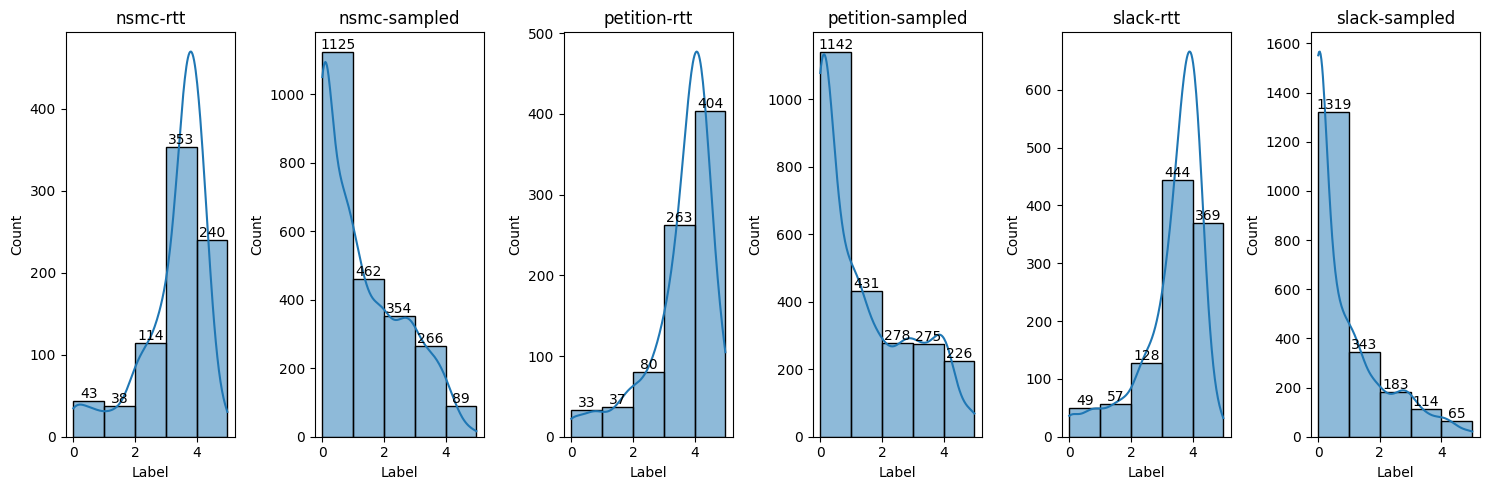

In [11]:
# train
sources = sorted(train["source"].unique())

# 서브플롯 생성
fig, axes = plt.subplots(1, len(sources), figsize=(15, 5))

# 각 source별로 히스토그램 그리기
for ax, source in zip(axes, sources):
    # 히스토그램 데이터
    hist_data = train[train["source"] == source]
    hist = sns.histplot(hist_data, x="label", bins=5, kde=True, ax=ax)

    # 막대 위에 숫자 추가
    for p in hist.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
        )

    ax.set_title(f"{source}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")

# 레이아웃 조정
plt.tight_layout()
plt.show()

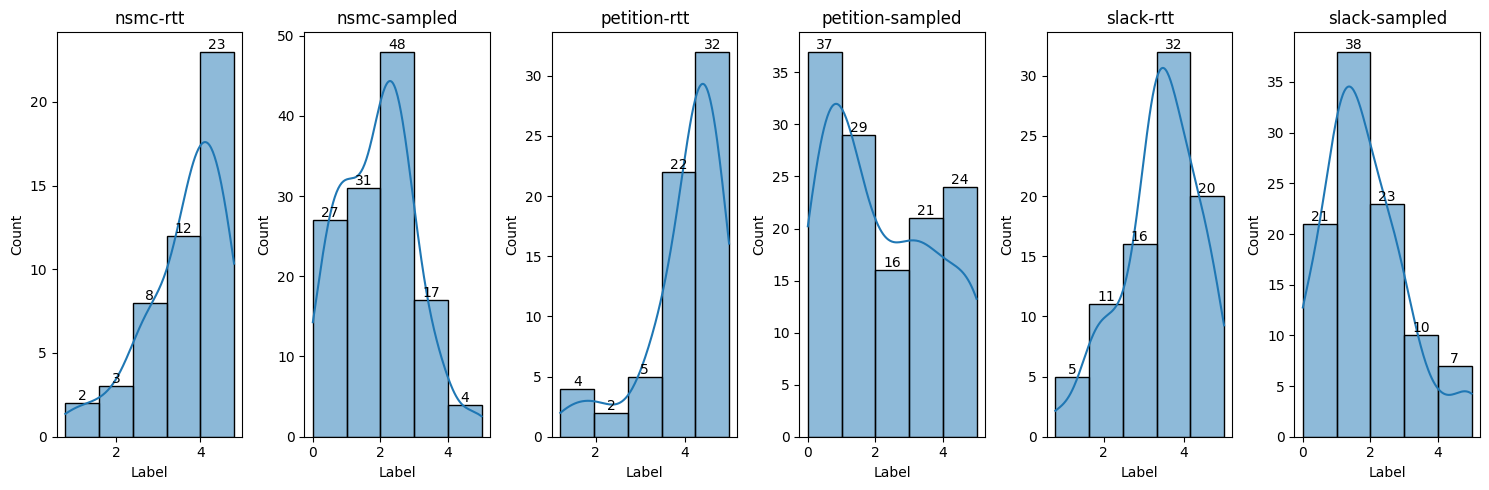

In [12]:
# dev
sources = sorted(dev["source"].unique())

# 서브플롯 생성
fig, axes = plt.subplots(1, len(sources), figsize=(15, 5))

# 각 source별로 히스토그램 그리기
for ax, source in zip(axes, sources):
    # 히스토그램 데이터
    hist_data = dev[dev["source"] == source]
    hist = sns.histplot(hist_data, x="label", bins=5, kde=True, ax=ax)

    # 막대 위에 숫자 추가
    for p in hist.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
        )

    ax.set_title(f"{source}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")

# 레이아웃 조정
plt.tight_layout()
plt.show()

## 텍스트

### 텍스트 길이

In [30]:
train["s1_len"] = train["sentence_1"].str.len()  # 문장1 길이
train["s2_len"] = train["sentence_2"].str.len()  # 문장2 길이
train["len_diff"] = (train["s1_len"] - train["s2_len"]).map(abs) # 문장 1,2 길이 차이

dev["s1_len"] = dev["sentence_1"].str.len()  # 문장1 길이
dev["s2_len"] = dev["sentence_2"].str.len()  # 문장2 길이
dev["len_diff"] = (dev["s1_len"] - dev["s2_len"]).map(abs)  # 문장 1,2 길이 차이

test["s1_len"] = test["sentence_1"].str.len()  # 문장1 길이
test["s2_len"] = test["sentence_2"].str.len()  # 문장2 길이
test["len_diff"] = (test["s1_len"] - test["s2_len"]).map(abs)  # 문장 1,2 길이 차이

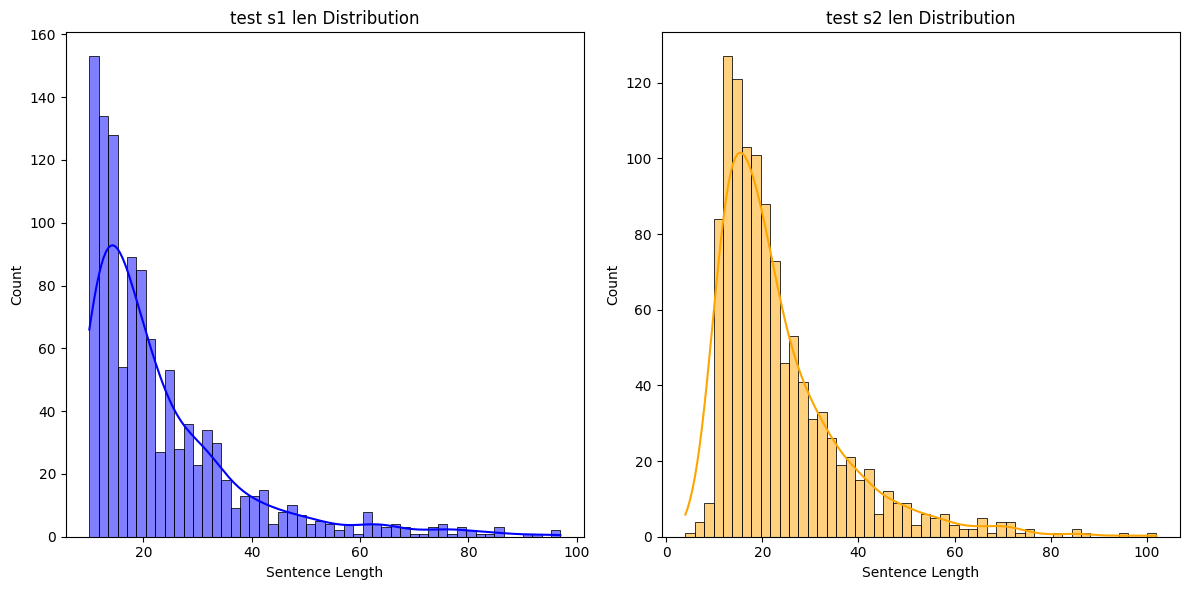

In [31]:
# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 서브플롯: s1_len
sns.histplot(test["s1_len"], kde=True, bins=50, color="blue", ax=axes[0])
axes[0].set_title("test s1 len Distribution")
axes[0].set_xlabel("Sentence Length")
axes[0].set_ylabel("Count")

# 두 번째 서브플롯: s2_len
sns.histplot(test["s2_len"], kde=True, bins=50, color="orange", ax=axes[1])
axes[1].set_title("test s2 len Distribution")
axes[1].set_xlabel("Sentence Length")
axes[1].set_ylabel("Count")

# 레이아웃 조정
plt.tight_layout()
plt.show()

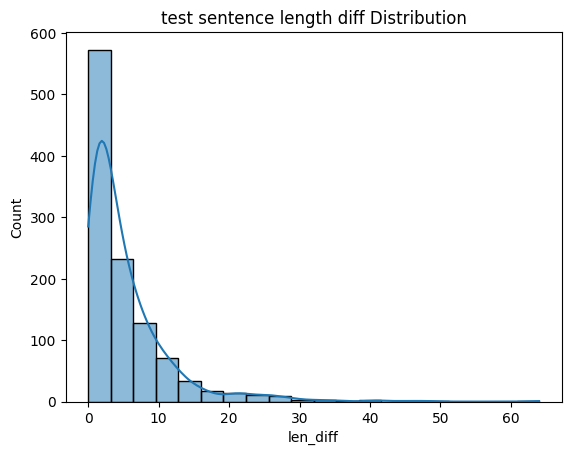

In [32]:
sns.histplot(test["len_diff"], kde=True, bins=20)
plt.title("test sentence length diff Distribution")
plt.xlabel("len_diff")
plt.ylabel("Count")
plt.show()

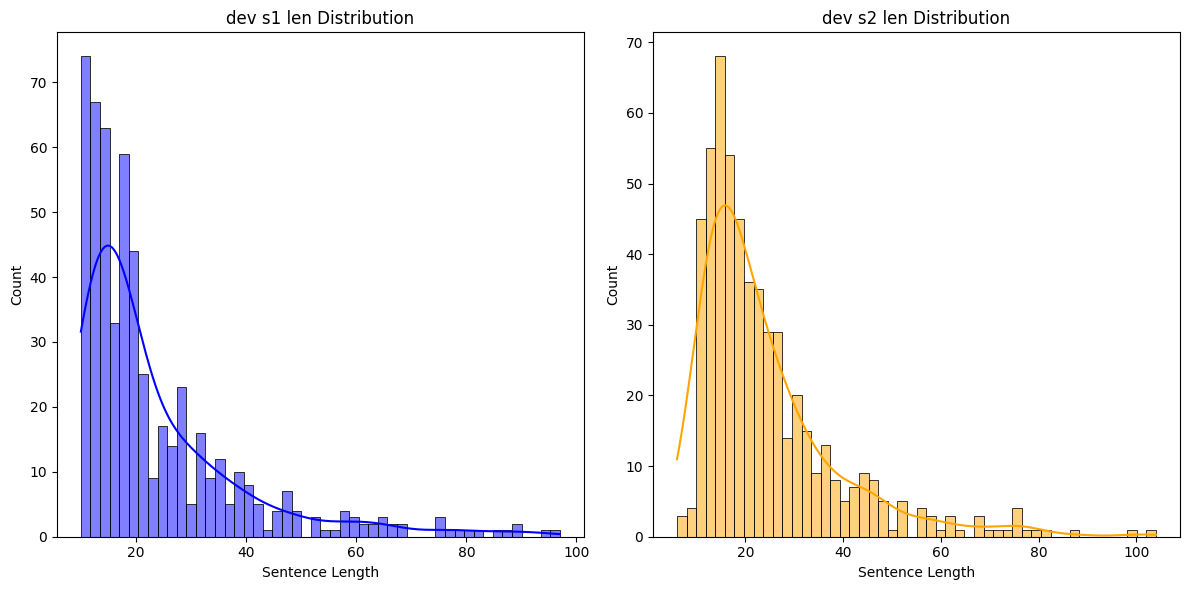

In [14]:
# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 서브플롯: s1_len
sns.histplot(dev["s1_len"], kde=True, bins=50, color="blue", ax=axes[0])
axes[0].set_title("dev s1 len Distribution")
axes[0].set_xlabel("Sentence Length")
axes[0].set_ylabel("Count")

# 두 번째 서브플롯: s2_len
sns.histplot(dev["s2_len"], kde=True, bins=50, color="orange", ax=axes[1])
axes[1].set_title("dev s2 len Distribution")
axes[1].set_xlabel("Sentence Length")
axes[1].set_ylabel("Count")

# 레이아웃 조정
plt.tight_layout()
plt.show()

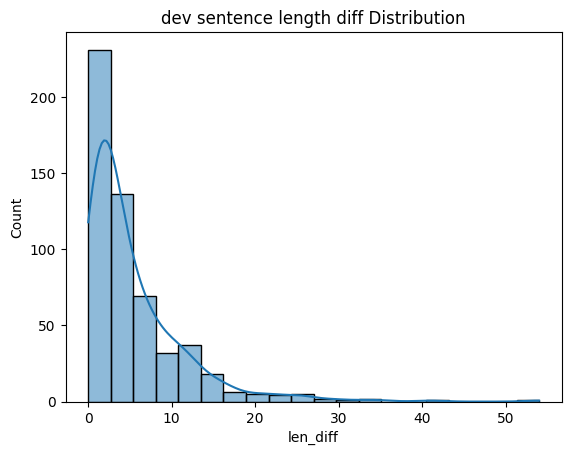

In [15]:
sns.histplot(dev["len_diff"], kde=True, bins=20)
plt.title("dev sentence length diff Distribution")
plt.xlabel("len_diff")
plt.ylabel("Count")
plt.show()

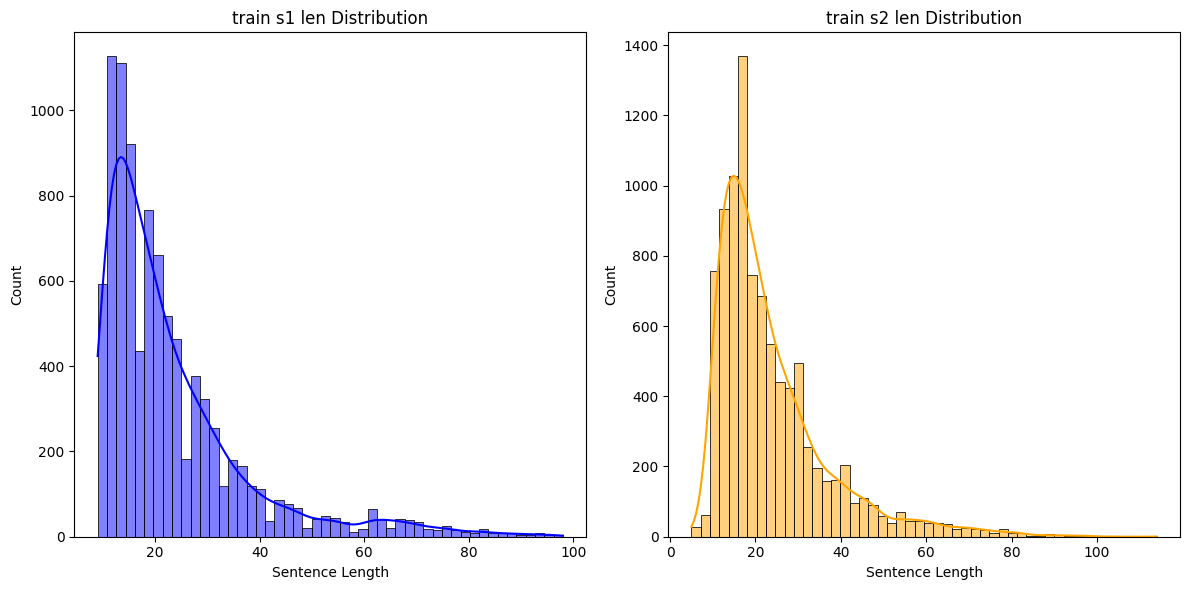

In [16]:
# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 서브플롯: s1_len
sns.histplot(train["s1_len"], kde=True, bins=50, color="blue", ax=axes[0])
axes[0].set_title("train s1 len Distribution")
axes[0].set_xlabel("Sentence Length")
axes[0].set_ylabel("Count")

# 두 번째 서브플롯: s2_len
sns.histplot(train["s2_len"], kde=True, bins=50, color="orange", ax=axes[1])
axes[1].set_title("train s2 len Distribution")
axes[1].set_xlabel("Sentence Length")
axes[1].set_ylabel("Count")

# 레이아웃 조정
plt.tight_layout()
plt.show()

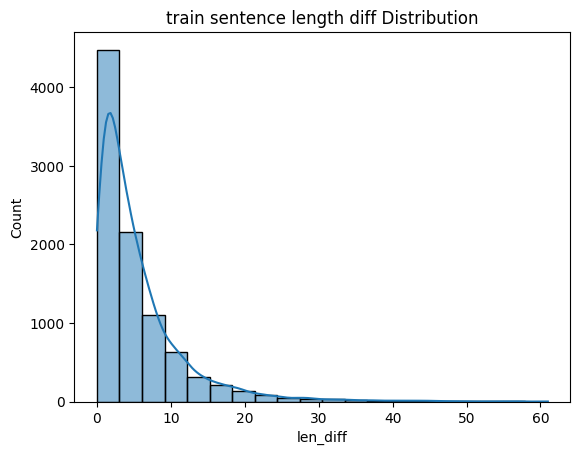

In [17]:
sns.histplot(train["len_diff"], kde=True, bins=20)
plt.title("train sentence length diff Distribution")
plt.xlabel("len_diff")
plt.ylabel("Count")
plt.show()

In [18]:
def plot_col1_col2_scatter(df, col1, col2, title=""):
    # Scatter plot 그리기
    plt.figure(figsize=(6, 6))
    plt.scatter(df[col1], df[col2], color="blue")

    # 그래프에 제목과 축 레이블 추가
    plt.title(f"{title} {col1} vs {col2}", fontsize=16)
    plt.xlabel(f"{col1}", fontsize=12)
    plt.ylabel(f"{col2}", fontsize=12)

    # 그래프 출력
    plt.show()

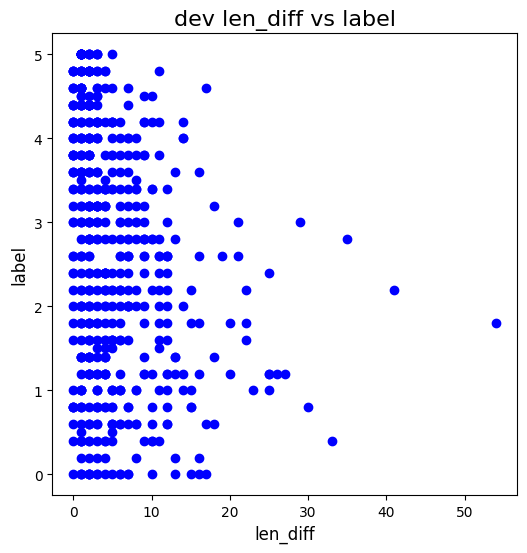

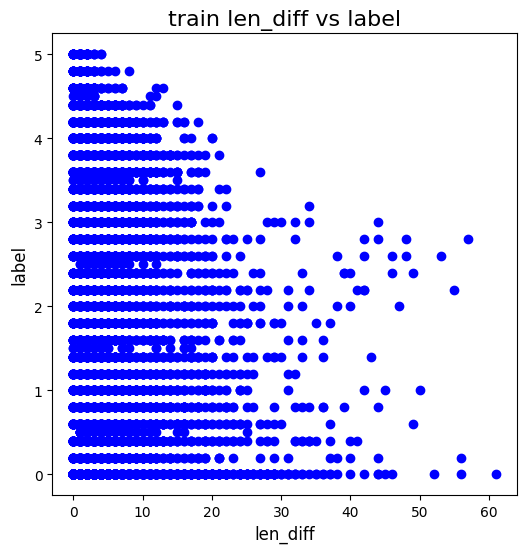

In [19]:
plot_col1_col2_scatter(dev,"len_diff", "label","dev")
plot_col1_col2_scatter(train, "len_diff", "label","train")

### 텍스트 BLEU Score
BLEU Score에 대한 개념과 구현은 다음 링크를 참고하세요.  
- 개념: https://supkoon.tistory.com/18  
- 개념 및 구현: https://wikidocs.net/31695  

In [20]:
from nltk.translate import bleu_score as bleu
chencherry = bleu.SmoothingFunction()

# train 데이터에 대한 BLEU 점수 계산
train["bleu"] = train.apply(
    lambda row: max(bleu.sentence_bleu(
        [row["sentence_1"].split()],
        row["sentence_2"].split(),
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=chencherry.method0,
    ), bleu.sentence_bleu(
        [row["sentence_2"].split()],
        row["sentence_1"].split(),
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=chencherry.method0,
    )),
    axis=1,
)

# dev 데이터에 대한 BLEU 점수 계산
dev["bleu"] = dev.apply(
    lambda row: max(bleu.sentence_bleu(
        [row["sentence_1"].split()],
        row["sentence_2"].split(),
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=chencherry.method0,
    ), bleu.sentence_bleu(
        [row["sentence_2"].split()],
        row["sentence_1"].split(),
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=chencherry.method0,
    )),
    axis=1,
)

In [21]:
print(len(train[train["bleu"]!=0]), len(dev[dev["bleu"]!=0]))

5065 368


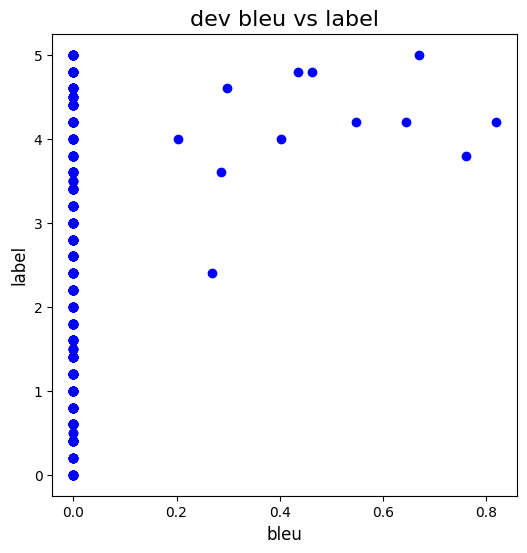

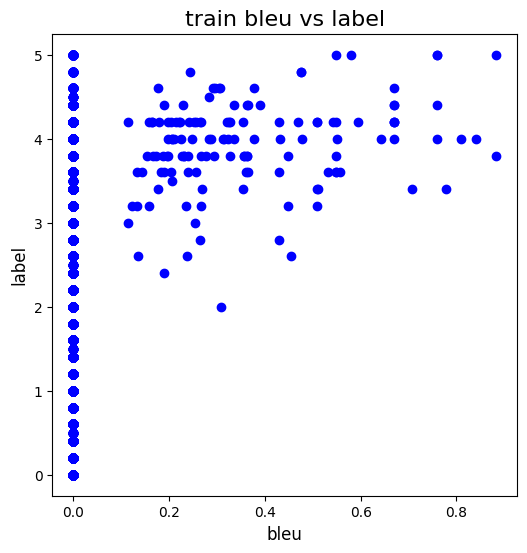

In [22]:
plot_col1_col2_scatter(dev, "bleu", "label", "dev")
plot_col1_col2_scatter(train, "bleu", "label","train")

### TF-IDF & Cosine Similarity

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_cos_sim(df):
    # TF-IDF 벡터화
    tfidf_vectorizer = TfidfVectorizer()

    # 문장 두 개를 결합하여 처리
    combined_sentences = df["sentence_1"].tolist() + df["sentence_2"].tolist()

    # TF-IDF 매트릭스 생성
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_sentences)

    # 문장1과 문장2의 코사인 유사도 계산
    # 첫 n개의 벡터는 sentence1, n부터는 sentence2에 해당
    cos_similarities = []
    n = len(df)
    for i in range(n):
        cos_sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[i + n])[0][0]
        cos_similarities.append(cos_sim)

    # 코사인 유사도 컬럼 추가
    df["cosine_similarity"] = cos_similarities

    return tfidf_matrix

tfidf_matrix_train = get_cos_sim(train)
tfidf_matrix_dev = get_cos_sim(dev)

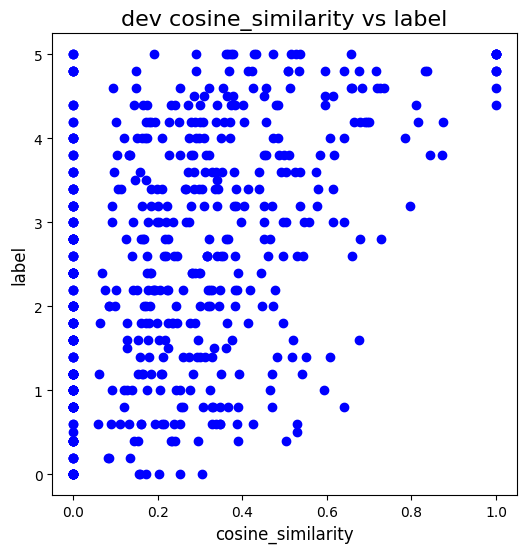

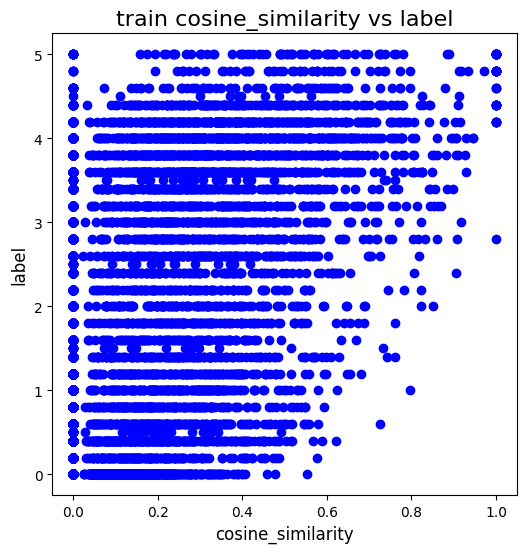

In [24]:
plot_col1_col2_scatter(dev, "cosine_similarity", "label","dev")
plot_col1_col2_scatter(train, "cosine_similarity", "label", "train")

### 텍스트 내용 분석

In [25]:
def print_text(df,n):
    for i in range(n):
        print(df["sentence_1"][i], "/", df["sentence_2"][i])
    print()

print_text(train, 10)
print_text(dev, 10)

스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ / 반전도 있고,사랑도 있고재미도있네요.
앗 제가 접근권한이 없다고 뜹니다;; / 오, 액세스 권한이 없다고 합니다.
주택청약조건 변경해주세요. / 주택청약 무주택기준 변경해주세요.
입사후 처음 대면으로 만나 반가웠습니다. / 화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.
뿌듯뿌듯 하네요!! / 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!
오마이가뜨지져스크롸이스트휏 / 오 마이 갓 지저스 스크론 이스트 팬
전 암만 찍어도 까만 하늘.. ㅠㅠ / 암만 찍어도 하늘은 까맣다.. ㅠㅠ
이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ / 이렇게 지겨운 공포영화는 처음..
미세먼지 해결이 가장 시급한 문제입니다! / 가장 시급한 것이 신생아실 관리입니다!!!
크림하우스 환불조치해주세요. / 크림하우스 환불조치할 수 있도록해주세여

액션은개뿔 총몇번쏘고 끝입니다 / 액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리
감격스러워 입막으심? / 너무 감동해서 입 다물어?
이번 년도에 본 영화 중 가장 최악의 영화...... / 올해 본 영화 중 최악...
특히 평소 뮤직채널에 많은 영감을 불어넣어주시는! / 특히, 당신은 항상 많은 음악 채널에 영감을 줍니다!
다음 밥스테이지가 기대됩니다~ ㅎ / 다음 후기도 기대됩니다~~
사진 간지.. ㅋㅋ 축하드립니다 / 사진이 나왔어요..ㅋㅋㅋ 축하드립니다.
영화보면서 기분전환이 되었어요 / 영화 보는 내내 뭔가 모를 편안함을 느꼈어요
건강하게 자라기를!! / 얼른 건강 회복하기를요!!!
고수님들의 많은 가르침 부탁드립니다 <PERSON> / 고수님들의 많은 지도 부탁드립니다 <PERSON>
러닝화 신었더니 뒤꿈치가 푹신해서 자꾸 앞으로 힘이 쏠리고 뒤꿈치 들리네요 / 런닝화를 신고 발 뒤꿈치가 부드러워서 계속 힘을 빼고 발뒤꿈치를 들어 올렸다.



### 텍스트 전처리
- 텍스트 전처리에는 다음과 같은 방법들을 적용할 수 있습니다.  
- 특수 문자 제거  
- 초성 대체 혹은 제거  
- 띄어쓰기 교정  
- 맞춤법 교정  
- `<PERSON>` 토큰 대체 혹은 special token으로 사용  

In [26]:
# 초성(ㄱ-ㅎ), 중성(ㅏ-ㅣ), 완성된 한글(가-힣), 알파벳(A-Za-z), 숫자(0-9), 그리고 공백(\s)만 허용
def replace_special_letters(df):
    df["sentence_1"] = df["sentence_1"].str.replace(
        r"[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ\s]", "", regex=True
    )
    df["sentence_2"] = df["sentence_2"].str.replace(
        r"[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ\s]", "", regex=True
    )

In [27]:
train_v2 = pd.read_csv("./data/raw/train.csv", encoding="UTF-8")
dev_v2 = pd.read_csv("./data/raw/dev.csv", encoding="UTF-8")

replace_special_letters(train_v2)
replace_special_letters(dev_v2)

print_text(train_v2, 5)
print_text(dev_v2, 5)

FileNotFoundError: [Errno 2] No such file or directory: './data/raw/train.csv'

In [69]:
# 초성 대체
def replace_consonant(df):
    df["sentence_1"] = df["sentence_1"].str.replace(r"[ㅋ]+", "웃음", regex=True)
    df["sentence_2"] = df["sentence_2"].str.replace(r"[ㅋ]+", "웃음", regex=True)
    df["sentence_1"] = df["sentence_2"].str.replace(r"[ㅎ]+", "웃음", regex=True)
    df["sentence_2"] = df["sentence_2"].str.replace(r"[ㅎ]+", "웃음", regex=True)

    df["sentence_1"] = df["sentence_1"].str.replace(r"[ㅜ]+", "슬픔", regex=True)
    df["sentence_2"] = df["sentence_2"].str.replace(r"[ㅜ]+", "슬픔", regex=True)
    df["sentence_1"] = df["sentence_1"].str.replace(r"[ㅠ]+", "슬픔", regex=True)
    df["sentence_2"] = df["sentence_2"].str.replace(r"[ㅠ]+", "슬픔", regex=True)

In [70]:
replace_consonant(train_v2)
replace_consonant(dev_v2)

print_text(train_v2, 5)
print_text(dev_v2, 5)

반전도 있고사랑도 있고재미도있네요 / 반전도 있고사랑도 있고재미도있네요
오 액세스 권한이 없다고 합니다 / 오 액세스 권한이 없다고 합니다
주택청약 무주택기준 변경해주세요 / 주택청약 무주택기준 변경해주세요
화상으로만 보다가 리얼로 만나니 정말 반가웠습니다 / 화상으로만 보다가 리얼로 만나니 정말 반가웠습니다
꼬옥 실제로 한번 뵈어요 뿌뿌뿌 / 꼬옥 실제로 한번 뵈어요 뿌뿌뿌
오 마이 갓 지저스 스크론 이스트 팬 / 오 마이 갓 지저스 스크론 이스트 팬
암만 찍어도 하늘은 까맣다 슬픔 / 암만 찍어도 하늘은 까맣다 슬픔
이렇게 지겨운 공포영화는 처음 / 이렇게 지겨운 공포영화는 처음
가장 시급한 것이 신생아실 관리입니다 / 가장 시급한 것이 신생아실 관리입니다
크림하우스 환불조치할 수 있도록해주세여 / 크림하우스 환불조치할 수 있도록해주세여

액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리 / 액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리
너무 감동해서 입 다물어 / 너무 감동해서 입 다물어
올해 본 영화 중 최악 / 올해 본 영화 중 최악
특히 당신은 항상 많은 음악 채널에 영감을 줍니다 / 특히 당신은 항상 많은 음악 채널에 영감을 줍니다
다음 후기도 기대됩니다 / 다음 후기도 기대됩니다
사진이 나왔어요웃음 축하드립니다 / 사진이 나왔어요웃음 축하드립니다
영화 보는 내내 뭔가 모를 편안함을 느꼈어요 / 영화 보는 내내 뭔가 모를 편안함을 느꼈어요
얼른 건강 회복하기를요 / 얼른 건강 회복하기를요
고수님들의 많은 지도 부탁드립니다 PERSON / 고수님들의 많은 지도 부탁드립니다 PERSON
런닝화를 신고 발 뒤꿈치가 부드러워서 계속 힘을 빼고 발뒤꿈치를 들어 올렸다 / 런닝화를 신고 발 뒤꿈치가 부드러워서 계속 힘을 빼고 발뒤꿈치를 들어 올렸다



In [79]:
# 띄어쓰기 교정
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
import pykospacing
spacing = pykospacing.Spacing() 

def spacing_text(df):
    df["sentence_1"] = df["sentence_1"].map(spacing)
    df["sentence_2"] = df["sentence_2"].map(spacing)

In [80]:
spacing_text(train_v2)
spacing_text(dev_v2)

print_text(train_v2, 5)
print_text(dev_v2, 5)

스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있고 사랑도 있고 재미도 있네요
앗 제가 접근 권한이 없다고 뜹니다 / 오 액 세스 권한이 없다고 합니다
주택청약 조건 변경해주세요 / 주택청약 무주택기준 변경해주세요
입사 후 처음 대면으로 만나 반가웠습니다 / 화상으로만 보다 가 리얼로 만나니 정말 반가웠습니다
뿌듯 뿌듯 하네요 / 꼬옥 실제로 한 번 뵈어요 뿌뿌뿌

액션은 개뿔 총 몇 번 쏘고 끝입니다 / 액션은 흉내만 내 고 그마저도 후반부에는 슬로우 모션 처리
감격스러워 입막으심 / 너무 감동해서 입 다 물어
이번 년도에 본 영화 중 가장 최악의 영화 / 올해 본 영화 중 최악
특히 평소 뮤직 채널에 많은 영감을 불어 넣어주시는 / 특히 당신은 항상 많은 음악 채널에 영감을 줍니다
다음 밥 스테이지가 기대됩니다 ㅎ / 다음 후기도 기대됩니다



In [35]:
# 불용어 제거
from nltk.tokenize import word_tokenize 

def remove_stop_word(df):
    def _do(target):
        stop_words = "아 휴 아이구 아이쿠 아이고 어"
        stop_words = stop_words.split(" ")
        word_tokens = word_tokenize(target)
        result = [word for word in word_tokens if not word in stop_words]
        return " ".join(result)
    df["sentence_1"] = df["sentence_1"].apply(_do)
    df["sentence_2"] = df["sentence_2"].apply(_do)

In [32]:
remove_stop_word(train_v2)
remove_stop_word(dev_v2)

print_text(train_v2, 5)
print_text(dev_v2, 5)

스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ / 반전도 있고 , 사랑도 있고재미도있네요 .
앗 제가 접근권한이 없다고 뜹니다 ; ; / 오 , 액세스 권한이 없다고 합니다 .
주택청약조건 변경해주세요 . / 주택청약 무주택기준 변경해주세요 .
입사후 처음 대면으로 만나 반가웠습니다 . / 화상으로만 보다가 리얼로 만나니 정말 반가웠습니다 .
뿌듯뿌듯 하네요 ! ! / 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~ ! ~ !

액션은개뿔 총몇번쏘고 끝입니다 / 액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리
감격스러워 입막으심 ? / 너무 감동해서 입 다물어 ?
이번 년도에 본 영화 중 가장 최악의 영화 ...... / 올해 본 영화 중 최악 ...
특히 평소 뮤직채널에 많은 영감을 불어넣어주시는 ! / 특히 , 당신은 항상 많은 음악 채널에 영감을 줍니다 !
다음 밥스테이지가 기대됩니다~ ㅎ / 다음 후기도 기대됩니다~~



### 데이터 증강 (EDA, Easy Data Augmentation)
- 개념 내용은 https://stages.ai/en/competitions/327/board/community/post/2783 참고하세요.  
- 코드는 https://github.com/catSirup/KorEDA 에서 가져왔습니다.  

In [81]:
import random
import pickle
import re

wordnet = {}
with open("./data/wordnet.pickle", "rb") as f:
    wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
    parseText = re.compile("/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/").sub("", line)

    return parseText


########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    if len(new_words) != 0:
        sentence = " ".join(new_words)
        new_words = sentence.split(" ")

    else:
        new_words = ""

    return new_words


def get_synonyms(word):
    synomyms = []

    try:
        for syn in wordnet[word]:
            for s in syn:
                synomyms.append(s)
    except:
        pass

    return synomyms


########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
    if len(words) == 1:
        return words

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    if len(new_words) == 0:
        rand_int = random.randint(0, len(words) - 1)
        return [words[rand_int]]

    return new_words


########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)

    return new_words


def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0

    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1
        if counter > 3:
            return new_words

    new_words[random_idx_1], new_words[random_idx_2] = (
        new_words[random_idx_2],
        new_words[random_idx_1],
    )
    return new_words


########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)

    return new_words


def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        if len(new_words) >= 1:
            random_word = new_words[random.randint(0, len(new_words) - 1)]
            synonyms = get_synonyms(random_word)
            counter += 1
        else:
            random_word = ""

        if counter >= 10:
            return

    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words) - 1)
    new_words.insert(random_idx, random_synonym)


def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, num_aug=9):
    sentence = get_only_hangul(sentence)
    words = sentence.split(" ")
    words = [word for word in words if word != ""]
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug / 3) + 1  # 3가지 증강 기법에 맞춰서 수정

    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))

    # sr: Synonym replacement
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(" ".join(a_words))

    # ri: Random insertion
    for _ in range(num_new_per_technique):
        a_words = random_insertion(words, n_ri)
        augmented_sentences.append(" ".join(a_words))

    # rs: Random swap
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(" ".join(a_words))

    # Hangul cleanup and shuffle
    augmented_sentences = [
        get_only_hangul(sentence) for sentence in augmented_sentences
    ]
    random.shuffle(augmented_sentences)

    # Limit the number of augmentations to num_aug
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [
            s for s in augmented_sentences if random.uniform(0, 1) < keep_prob
        ]

    # Original sentence 포함
    augmented_sentences.append(sentence)

    return augmented_sentences

In [82]:
# EDA 적용 함수
def apply_eda(df, num_aug=2):
    def conditional_EDA(row, column_name):
        if row["label"] >= 1:  
            return EDA(row[column_name], num_aug=num_aug)
        else:
            return [row[column_name]]

    df["sentence_1"] = df.apply(lambda row: conditional_EDA(row, "sentence_1"), axis=1)
    df = df.explode("sentence_1").reset_index(drop=True)
    
    df["sentence_2"] = df.apply(lambda row: conditional_EDA(row, "sentence_2"), axis=1)
    df = df.explode("sentence_2").reset_index(drop=True)

    return df

In [83]:
train_v3 = pd.read_csv("./data/raw/train.csv", encoding="UTF-8")
train_v3 = apply_eda(train_v3)

In [99]:
print_text(train_v3, 10)
print(len(train_v3))

스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있고 사랑도 있고 재미도 있네요
스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 사랑도 있고 반전도 있고 재미도 있네요
스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있고 사랑도 있고 재미도 있네요
스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있고 사랑도 있고 재미도 있네요
스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있고 사랑도 있고 재미도 있네요
스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있고 사랑도 있고 재미도 있네요
스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있고 사랑도 있고 재미도 있네요
스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있네요 사랑도 있고 재미도 있고
스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요 / 반전도 있고 사랑도 있고 재미도 있네요
앗 접 제가 접근 권한이 없다고 뜹니다 / 오 액 세스 권한이 없다고 합니다

54228
